In [1]:
#%matplotlib notebook
%matplotlib inline
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"




C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Modules loaded
Reload complete
GPUs available: 1


In [2]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])


config_file = 'C:/Users/awoloshu/Documents/NephNet/saved/weights_denseModel/config.json'
saved_dir = 'C:/Users/awoloshu/Documents/NephNet/saved/weights_denseModel'
config_saved_filename = os.path.join(saved_dir, "config.json")
resume = os.path.join(saved_dir, "model_best.pth")



# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [ ]:



data_loader = getattr(module_data, config['data_loader_test']['type'])(
    'C:/Users/awoloshu/Desktop/datasets/NephNet/3d_all/train3344_test59/dataset.h5',
    batch_size=1,
    shuffle=True,
    validation_split=0.0,
    training=True,
    num_workers=0,
    mean = 15.0,
    stdev = 18.43)
print("Total number of training images = " + str(data_loader.dataset.data_len))
valid_data_loader = data_loader.split_validation() #allocate some images as validation

normalized = False
util.visualizeBatch(data_loader, normalized) 

Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Total number of training images = 139617


In [3]:
model = get_instance(module_arch, 'arch', config)
print(model)
# get function handles of loss and metrics
loss_fn = getattr(module_loss, config['loss'])
criterion = loss_fn(None)
metric_fns = [getattr(module_metric, met) for met in config['metrics']]

# load state dict
checkpoint = torch.load(resume)
state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
if config['n_gpu'] > 1:
    model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict) 

# prepare model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval() #tells model to ignore dropout and batch normalization

total_loss = 0.0
total_metrics = torch.zeros(len(metric_fns))

classes = ('s1', 's2', 'TAL' ,'DCT', 'CD', 'CD45', 'nestin', 'cd31glom', 'cd31int')
all_pred = []
all_true = []
hm_layers = {'final_layer': 'conv_layer4', 'fc_layer': 'fc7', 'conv_num': 2, 'fc_num': 0}








Dense3D(
  (relu): LeakyReLU(negative_slope=0.01)
  (low_conv): Conv3d(1, 96, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (dense1): Sequential(
    (0): DenseBlock(
      (relu): LeakyReLU(negative_slope=0.01)
      (bn): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv3d(96, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv3): Conv3d(96, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv4): Conv3d(144, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv5): Conv3d(192, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
  )
  (t1): Sequential(
    (0): TransitionBlock(
      (relu): LeakyReLU(negative_slope=0.01)
      (bn): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv3d(240, 192, ke

In [4]:
%matplotlib inline
from ipywidgets import widgets, interact
def visualizeFilters(filters):
    '''
    Visualize all the filters as an array that can be scrolled through
    '''
    fin, fout, kerz, kery, kerx = filters.shape
    print(filters.shape)
    montage = np.zeros((kerz,int(fin*kery/12), int(fin*kerx/8)))
    print(montage.shape)
    row = 0
    col = 0
    for i, filt in enumerate(filters):
        filt = np.squeeze(filt)
        if col+kerx > montage.shape[1]:
            row+=kerx
            col = 0
        a = montage[:,col:col+kerx, row:row+kerx]
        #print("{} {} {}".format(row, col, i*5))
        montage[:,col:col+kerx, row:row+kerx ] = filt
        col +=kerx
    print("========================================")
    montage = (montage - np.min(np.ravel(montage)))/ ( np.max(np.ravel(montage)) -  np.min(np.ravel(montage)))
    
    def update_layer(layer = 0):
            plt.imshow(montage[layer], cmap ='gray')
            plt.show()
            
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.title("Montage of first convolutional filters")
    plt.imshow(montage[0], cmap ='gray')
    interact(update_layer, layer=widgets.IntSlider(min=0,max=montage.shape[0]-1,step=1,value=0))

   

(96, 1, 5, 5, 5)
(5, 40, 60)


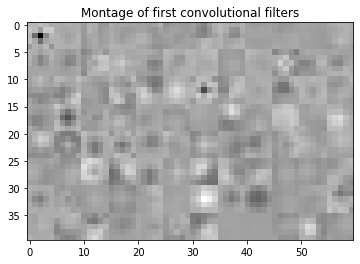

interactive(children=(IntSlider(value=0, description='layer', max=4), Output()), _dom_classes=('widget-interac…

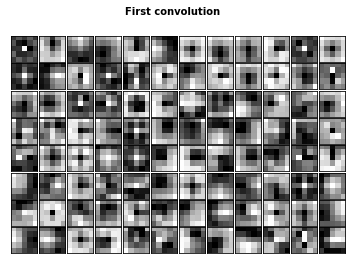

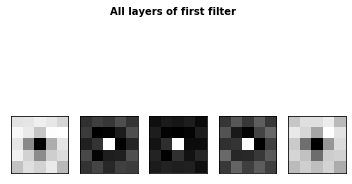

In [36]:
for m in model.modules():
    if isinstance(m, nn.Conv3d):
        fin, fout, kerx, kery, kerz = m.weight.data.cpu().numpy().shape
        if kerx == 5:
            filters = m.weight.data.cpu().numpy()
            visualizeFilters(filters)
            fig, axs = plt.subplots(8, 12,facecolor='w', edgecolor='k')
            plt.suptitle(("First convolution"),
                 fontsize=10, fontweight='bold')
            axs = axs.ravel()
            fig.subplots_adjust(hspace = 0.05, wspace= 0.05)
            for i in range(fin):
                filt = np.squeeze(filters[i])[3]
                axs[i].imshow(filt, cmap = 'gray')
                axs[i].set_xticks([])
                axs[i].set_yticks([])
            plt.show()    
            plt.pause(0.1)
            fig1, axs1 = plt.subplots(1, 5,facecolor='w', edgecolor='k')
            plt.suptitle(("All layers of first filter"),
                 fontsize=10, fontweight='bold')
            axs1 = axs1.ravel()
            fig.subplots_adjust(hspace = 0.05, wspace= 0.05)
            for i in range(5):
                filt = np.squeeze(filters[0])[i]
                axs1[i].imshow(filt, cmap = 'gray')
                axs1[i].set_xticks([])
                axs1[i].set_yticks([])
            plt.show() 
                
        

In [5]:
data_loader = getattr(module_data, config['data_loader_test']['type'])(
    'C:/Users/awoloshu/Desktop/datasets/Train44test33/3d_all/33/dataset_0.h5',
    batch_size=1,
    shuffle=True,
    validation_split=0.0,
    training=False,
    num_workers=0,
    mean = 15.42,
    stdev = 18.75)
print("data loader created")

Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


data loader created


torch.Size([1, 1, 7, 32, 32])
torch.Size([1])
15.42


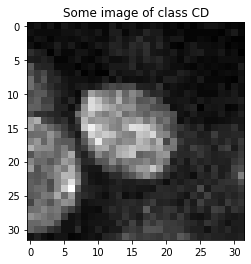

In [6]:
data, label = next(iter(data_loader))
print(data.shape)
print(label.shape)
img = np.squeeze(data[0].numpy())
fig = plt.figure(figsize = (4,4))
plt.imshow(img[2], cmap = 'gray')
plt.title("Some image of class {}".format(classes[int(np.squeeze(label[0].numpy()))]))


In [7]:
#model = model.module
#print(model)
#a = nn.Sequential(model_gp.low_conv, list(*model_gp.low_conv))
modulelist = nn.Sequential(model.module.relu, model.module.low_conv, model.module.dense1[0], 
                           model.module.t1[0], model.module.dense2[0], model.module.t2[0])
print(len(modulelist))
print(modulelist[:])


6
Sequential(
  (0): LeakyReLU(negative_slope=0.01)
  (1): Conv3d(1, 96, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (2): DenseBlock(
    (relu): LeakyReLU(negative_slope=0.01)
    (bn): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv3d(96, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (conv2): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (conv3): Conv3d(96, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (conv4): Conv3d(144, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (conv5): Conv3d(192, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (3): TransitionBlock(
    (relu): LeakyReLU(negative_slope=0.01)
    (bn): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv3d(240, 192, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (pool): AvgPool3d(kernel_size=2, str

torch.Size([7, 32, 32])
torch.Size([7, 32, 32])
torch.Size([7, 32, 32])
torch.Size([7, 32, 32])
torch.Size([3, 16, 16])
torch.Size([3, 16, 16])
torch.Size([1, 8, 8])


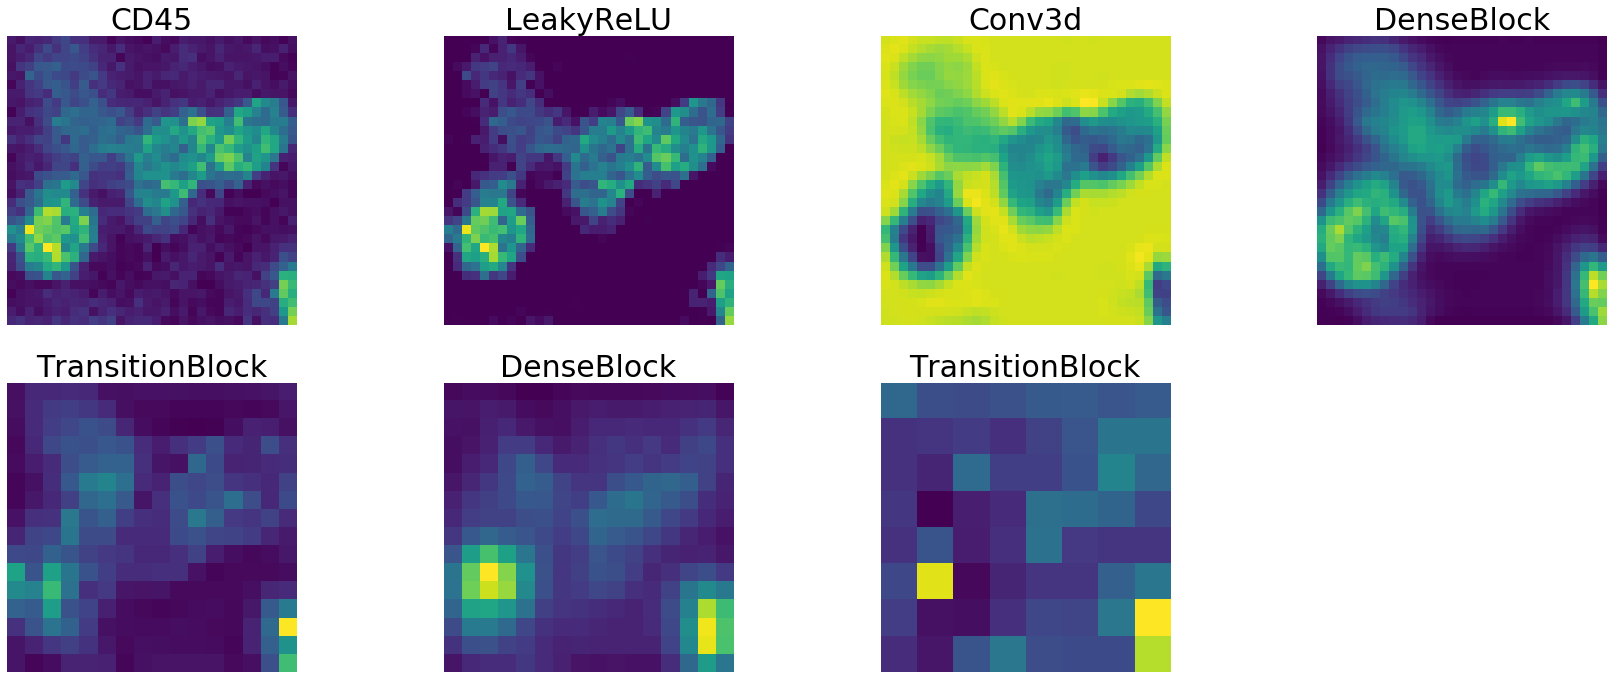

In [8]:
data, label = next(iter(data_loader))
lab = classes[int(np.squeeze(label.numpy()))]
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def layer_outputs(image):
    outputs = []
    names = []
    outputs.append(image)
    names.append(lab)
    for layer in modulelist[:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
        
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)
        print(temp.shape)
        if temp.shape[0] > 1:
            temp = temp[int(temp.shape[0]/2)]
        else:
            temp = temp[0]
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure(figsize = (30, 50))
#    plt.rcParams["figure.figsize"] = (30, 50)


    for i in range(len(output_im)):
        a = fig.add_subplot(8,4,i+1)
        imgplot = plt.imshow(output_im[i])
        plt.axis('off')
        a.set_title(names[i].partition('(')[0], fontsize=30)

    #plt.savefig('layer_outputs.jpg', bbox_inches='tight')
    

layer_outputs(data.cuda())

(96, 7, 32, 32)
(32, 32)


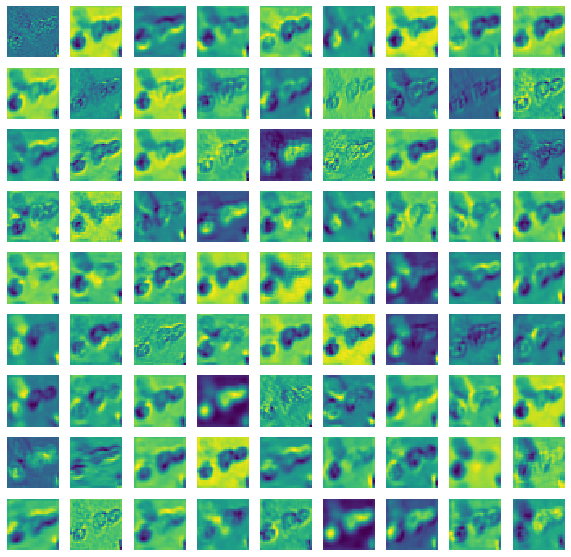

In [10]:
def filter_outputs(image, layer_to_visualize):
    if layer_to_visualize < 0:
        layer_to_visualize += len(modulelist)-1
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    #output = output.data.squeeze()
    output = output.cpu()
    output = output[0].detach().cpu().numpy()
    print(output.shape)
    for i in range(output.shape[0]):
        if output.shape[1] > 1:
            depth = int(output.shape[1]/2)
            im = output[i,depth,:,:]
        else:
            im = output[i,0,:,:]
        filters.append(im)
        if i == 1: print(filters[0].shape)
        
    fig = plt.figure(figsize = (10,10))
    #plt.rcParams["figure.figsize"] = (10, 10)

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)),i+1)
        imgplot = plt.imshow(filters[i])
        plt.axis('off')
        
filter_outputs(data.cuda(), 0)

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ValueError: not enough values to unpack (expected 3, got 2)

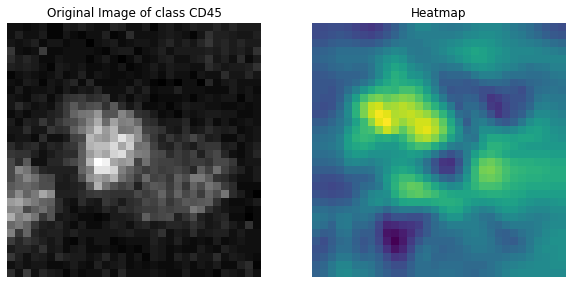

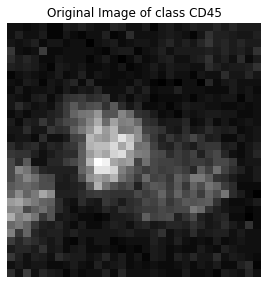

In [111]:
from torch.autograd import Variable
from scipy.ndimage import zoom
def make_heatmap(image, true_class, k=3, stride=3): 
    #print(image.shape)
    """
    Input image is of size (1, c, w, h) typically (1, 3, 224, 224) for vgg16
    true_class is a number corresponding to imagenet classes
    k in the filter size (c, k, k)
    
    
    input image is of size (1, c, d, w, h) typically (1, 1, 7, 32, 32)
    k in the filter size (k,k,k)
    """

    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), 
                          int(((image.shape[3]-k)/stride)+1),
                          int(((image.shape[4]-k)/stride)+1))
    #print(heatmap.shape) #2 10 10 
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            z = 0
            d = 0
            while z<= image.shape[4] - k:
                h_filter = torch.ones(image.shape)
                h_filter[:,:,j:j+k, i:i+k, z:z+k] = 0
                temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
                temp_softmax = model(temp_image)
                temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
                heatmap[b][a][d] = temp_softmax[true_class]
                
                d+=1
                z+=stride
            j += stride
            b += 1
        #print(a)
        i += stride
        a += 1
    
    image = image.squeeze()
    true_image = image
    #true_image = image.transpose(0,1)
    #true_image = true_image.transpose(1,2)
    # Un-Normalize image
    #true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    true_image = true_image*torch.Tensor([data_loader.stdev]).cuda() + torch.Tensor([data_loader.mean]).cuda()
    true_image = true_image.detach().cpu().numpy()
    
    
    # Plot both images
    fig = plt.figure(figsize  = (10,10))
    #plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    #MAX PROJECTION
    true_image = np.max(true_image, axis = 0)
    imgplot = plt.imshow(true_image, cmap = 'gray')
    
    #imgplot = plt.imshow(true_image[2], cmap = 'gray')
    plt.title('Original Image of class {}'.format(classes[int(np.squeeze(label.numpy()))]))
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap = heatmap - heatmap.min()
#     heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    z,x,y = heatmap.shape
    heatmap = zoom(heatmap, (7/z,32/x,32/y))
    a = fig.add_subplot(1,2,2)
    
    #MAX PROJECTION
    heatmap = np.max(heatmap, axis = 0)
    imgplot = plt.imshow(heatmap)
    #imgplot = plt.imshow(heatmap[2])
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap

data, label = next(iter(data_loader))
lab = classes[int(np.squeeze(label.numpy()))]
true_class = int(np.squeeze(label.numpy()))
hm = make_heatmap(data.cuda(), true_class, k=3, stride=3)

for i in range(1):
    fig = plt.figure(figsize  = (10,10))
    #plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    image = data.cuda().squeeze()
    true_image = image
    #true_image = image.transpose(0,1)
    #true_image = true_image.transpose(1,2)
    # Un-Normalize image
    #true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    true_image = true_image*torch.Tensor([data_loader.stdev]).cuda() + torch.Tensor([data_loader.mean]).cuda()
    true_image = np.max(true_image.detach().cpu().numpy(), axis = 0)
    imgplot = plt.imshow(true_image, cmap = 'gray')
    plt.title('Original Image of class {}'.format(classes[int(np.squeeze(label.numpy()))]))
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap =hm
    #heatmap = heatmap - heatmap.min()
    heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    z,x,y = heatmap.shape
    heatmap = zoom(heatmap, (7/z,32/x,32/y))
    heatmap = np.max(heatmap, axis=0)
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(15, 32, 32)


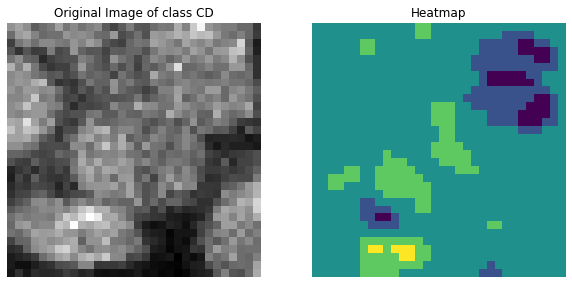

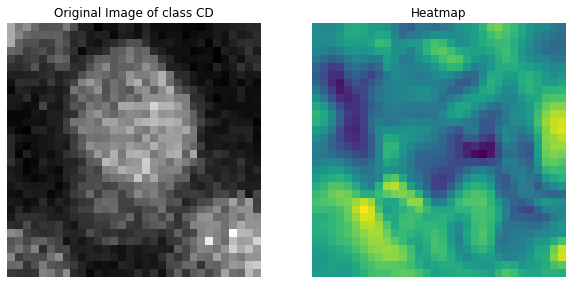

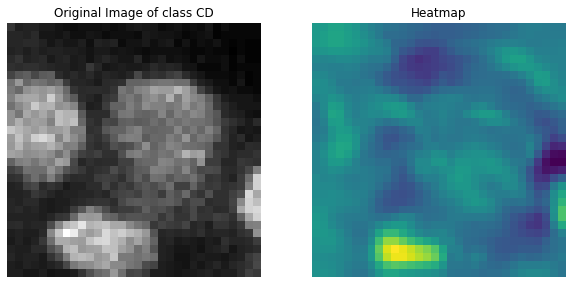

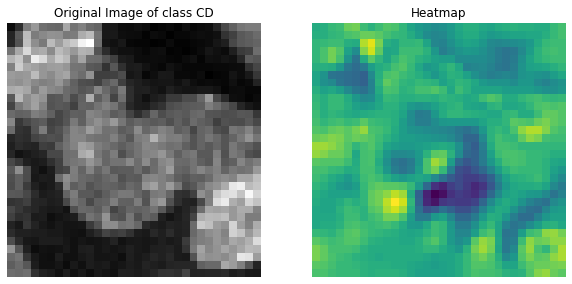

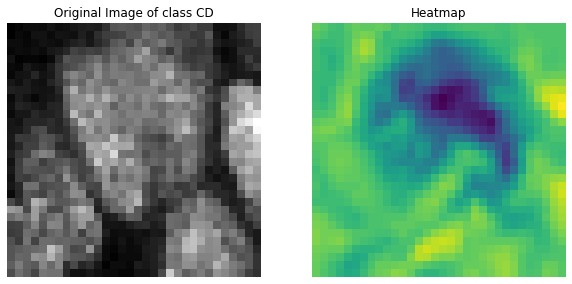

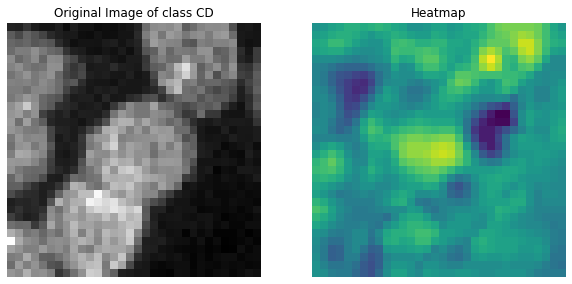

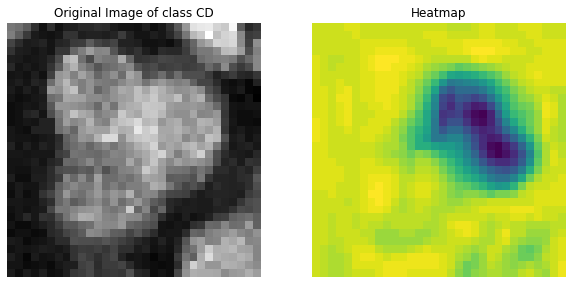

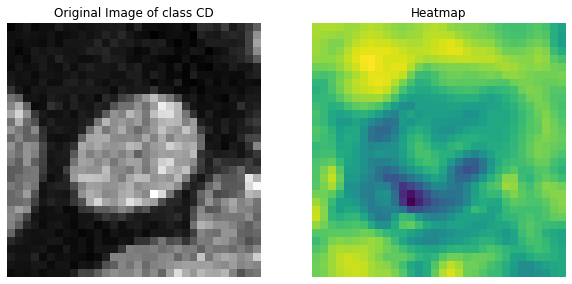

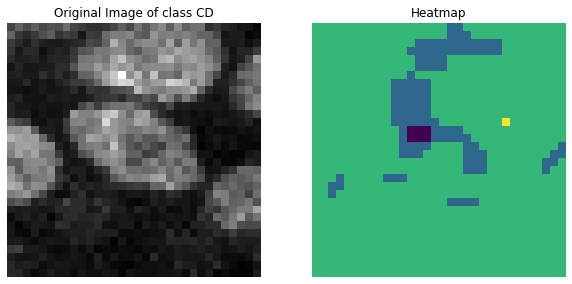

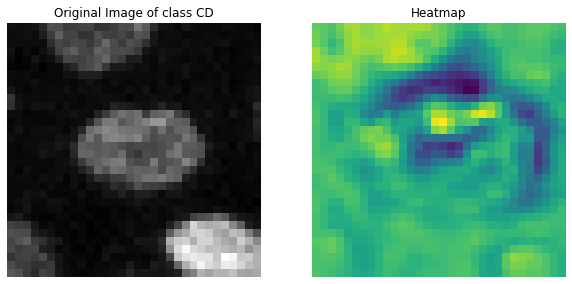

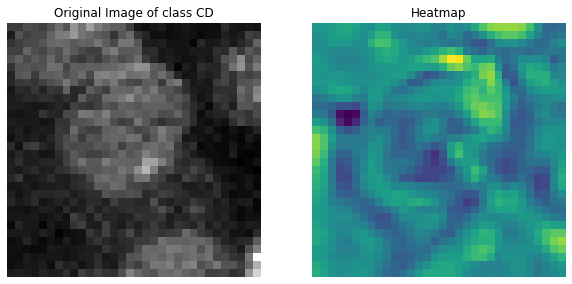

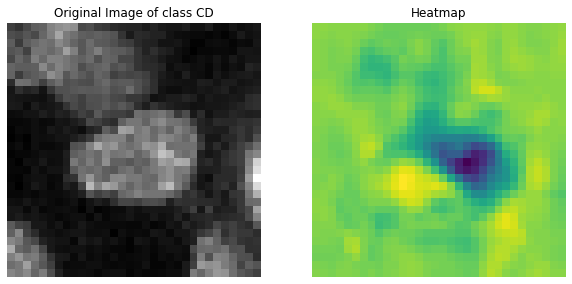

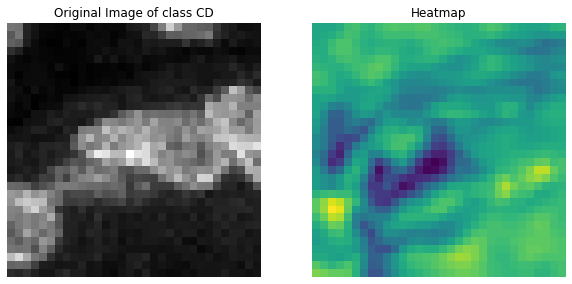

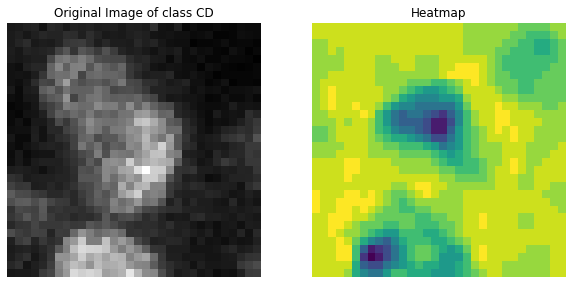

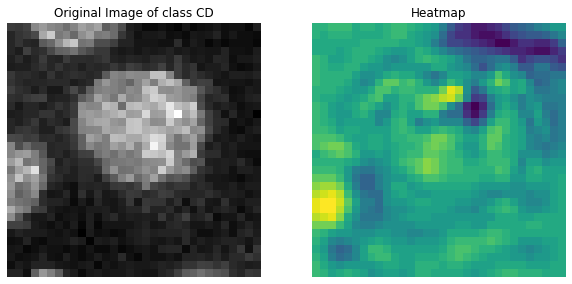

In [113]:
i = 0
hms = []
while i < 15:
    data, label = next(iter(data_loader))
    lab = classes[int(np.squeeze(label.numpy()))]
    
    softmax = model(data)
    prediction = np.argmax(softmax.detach().cpu().numpy())
    true_class = int(np.squeeze(label.numpy()))
    if true_class != 4 or prediction != true_class:
        continue
    i += 1
    hm = make_heatmap(data.cuda(), true_class, k=3, stride=2)
    hms.append(hm)
    
hms = np.array(hms)
print(hms.shape)


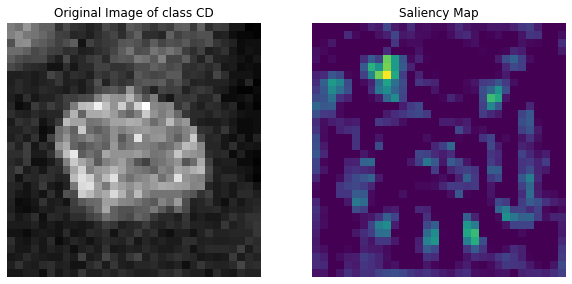

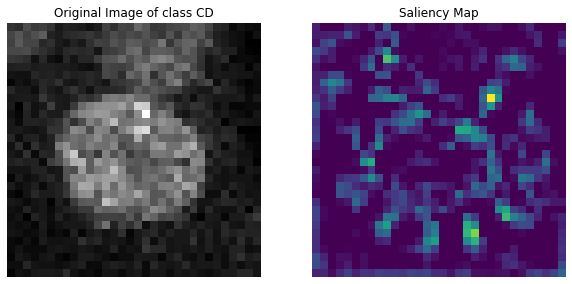

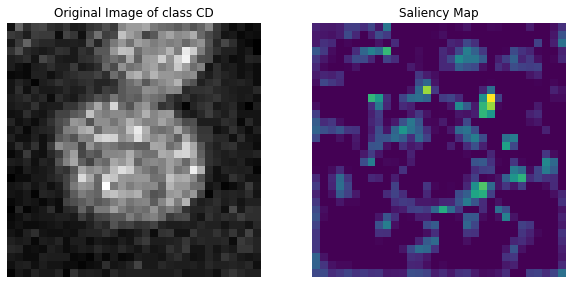

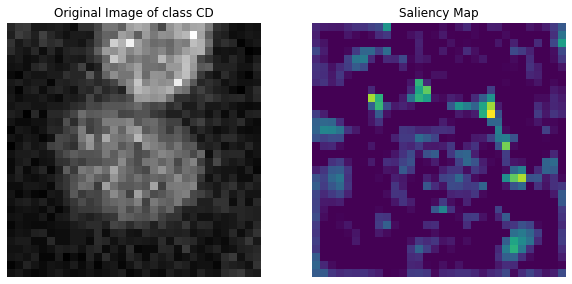

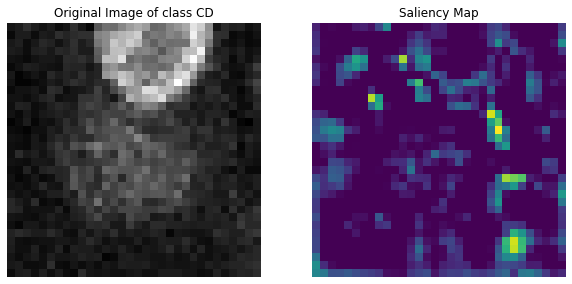

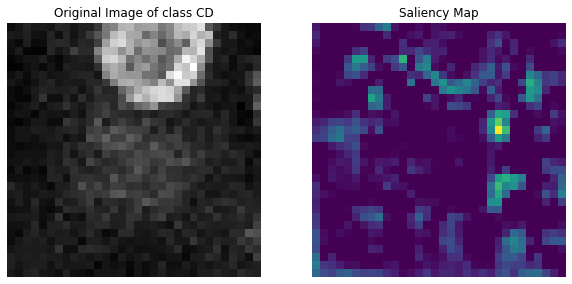

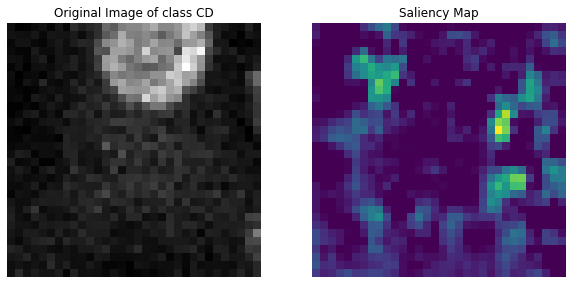

In [41]:
def make_saliency_map(input, label, idx2plot=3):
    input = Variable(input.cuda(), requires_grad=True)
    output = model.forward(input)
    output[0][label].backward()
    grads = input.grad.data.clamp(min=0)
    grads.squeeze_()
    #grads = np.amax(grads.cpu().numpy(), axis=0)
    grads = grads.detach().cpu().numpy()
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image*torch.Tensor([data_loader.stdev]).cuda() + torch.Tensor([data_loader.mean]).cuda()
    true_image = true_image.detach().cpu().numpy()

    fig = plt.figure(figsize=(10,10))
    #plt.rcParams["figure.figsize"] = (20, 20)

    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image[idx2plot], cmap = 'gray')
    plt.title('Original Image of class {}'.format(classes[int(np.squeeze(label))]))
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads[idx2plot])
    plt.axis('off') 
    plt.title('Saliency Map')
    
    return grads

data, label = next(iter(data_loader))
lab = classes[int(np.squeeze(label.numpy()))]
true_class = int(np.squeeze(label.numpy()))
for i in range(7):
    grads = make_saliency_map(data.cuda(), true_class, idx2plot = i)

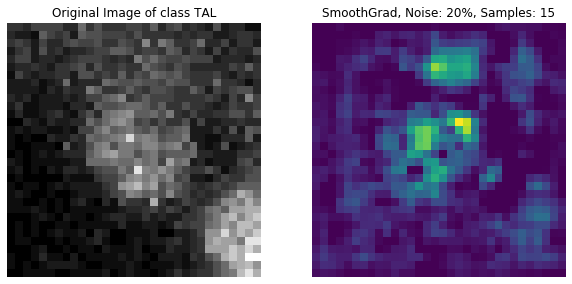

In [95]:
def smooth_grad(input, label, x=10, percent_noise=10, idx2plot = 2):
    """
    The apparent noise one sees in a sensitivity map may be due to 
    essentially meaningless local variations in partial derivatives.
    After all, given typical training techniques there is no reason to expect derivatives to vary smoothly.
    """
    tensor_input = data.cuda()
    # x is the sample size
    final_grad = torch.zeros((1,1,7,32,32)).cuda()
    for i in range(x):
        #print('Sample:', i+1)
        temp_input = Variable(input.cuda(), requires_grad=True)
        # According to the paper, noise level corrresponds to stddev/(xmax-xmin). Hence stddev = noise_percentage * (max-min) /100
        noise = torch.from_numpy(np.random.normal(loc=0, scale=(percent_noise/100) * (tensor_input.cpu().max() - tensor_input.cpu().min()),
                                                  size=temp_input.shape)).type(torch.cuda.FloatTensor)
        temp_input = (temp_input + noise)
        temp_input = Variable(temp_input.cuda(), requires_grad=True)

        output = model.forward(temp_input)
        output[0][label].backward()
        final_grad += temp_input.grad.data
    
    grads = final_grad/x
    grads = grads.clamp(min=0)
    grads.squeeze_()
    #grads = np.amax(grads.cpu().numpy(), axis=0)
    grads = grads.detach().cpu().numpy()
    
    true_image = input.cuda()
    true_image = true_image.squeeze()
    true_image = true_image*torch.Tensor([data_loader.stdev]).cuda() + torch.Tensor([data_loader.mean]).cuda()
    true_image = true_image.detach().cpu().numpy()

    fig = plt.figure(figsize = (10,10))
    #plt.rcParams["figure.figsize"] = (10, 10)

    #plot max projection only
    true_image = np.max(true_image, axis = 0)
    grads = np.max(grads, axis = 0)
    
    a = fig.add_subplot(1,2,1)
    #imgplot = plt.imshow(true_image[idx2plot], cmap = 'gray')
    imgplot = plt.imshow(true_image, cmap = 'gray')
    plt.title('Original Image of class {}'.format(lab))
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    #imgplot = plt.imshow(grads[idx2plot])
    plt.axis('off')  
    plt.title('SmoothGrad, Noise: ' + str(percent_noise) + '%, ' + 'Samples: ' + str(x))
    
    return grads

data, label = next(iter(data_loader))
lab = classes[int(np.squeeze(label.numpy()))]
true_class = int(np.squeeze(label.numpy()))
grads = smooth_grad(data, true_class, x=15, percent_noise=20, idx2plot = i)
for i in range(7):
    a=i
    #grads = smooth_grad(data, true_class, x=15, percent_noise=20, idx2plot = i)

In [ ]:
heatmapper = classActivationMap.CAMgenerator3d(hm_layers, config, model)
heatmapper.generateImage(num_images=10)

Sequential(
  (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (8): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (11): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): LeakyReLU(negative_slope=0.01)
  (13): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding

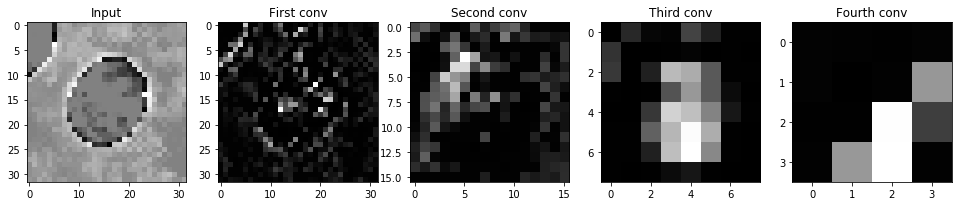

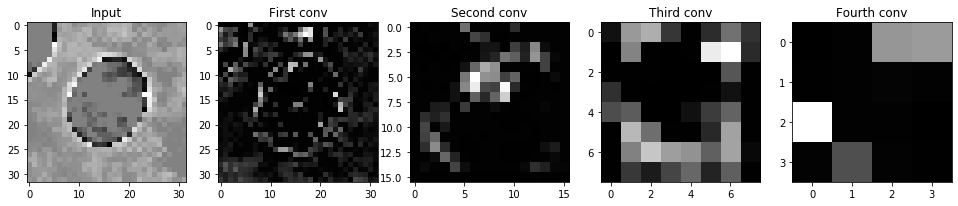

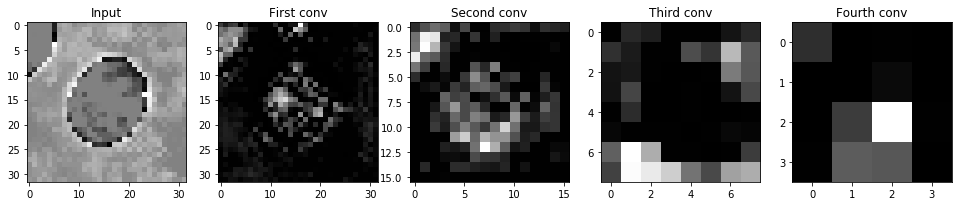

'\nfor i in range(3):\n    plt.subplot(1,5,1)\n    plt.title("Input")\n    plt.imshow(np.squeeze(inputs[0].cpu().detach().numpy())[3], cmap = \'gray\')\n    plt.subplot(1,5,2)\n    plt.title("First conv")\n    plt.imshow(img1[i][0], cmap=\'gray\')\n    plt.subplot(1,5,3)\n    plt.title("Second conv")\n    plt.imshow(img2[i][0], cmap=\'gray\')\n    plt.subplot(1,5,4)\n    plt.title("Third conv")\n    plt.imshow(img3[i][0], cmap=\'gray\')\n    plt.pause(0.1)\n    plt.subplot(1,5,5)\n    plt.title("Fourth conv")\n    plt.imshow(img4[i][0], cmap=\'gray\')\n    plt.pause(0.1)\n'

In [12]:
model_convs = nn.Sequential(*list(model.children())[0], *list(model.children())[1],
                           *list(model.children())[2], *list(model.children())[3])
#print(model_convs)
model_conv1 = nn.Sequential(*list(model_convs.children())[0:6])
model_conv2 = nn.Sequential(*list(model_convs.children())[0:13])
model_conv3 = nn.Sequential(*list(model_convs.children())[0:20])
model_conv4 = nn.Sequential(*list(model_convs.children()))
print(model_conv3)

inputs, labels = next(iter(data_loader))
torchsummary.summary(model_conv4, (1,7,32,32))
print(inputs.shape)
inputs = inputs.cuda()
output1 = model_conv1(inputs)
output2 = model_conv2(inputs)
output3 = model_conv3(inputs)
output4 = model_conv4(inputs)

print(output1.cpu().shape)
print(output2.cpu().shape)
print(output3.cpu().shape)

IMG_IDX = 0
img1 = output1.cpu().detach().numpy()[IMG_IDX]
img2 = output2.cpu().detach().numpy()[IMG_IDX]
img3 = output3.cpu().detach().numpy()[IMG_IDX]
img4 = output4.cpu().detach().numpy()[IMG_IDX]

classes = ('Glomerulus', 'Proximal Tubule', 'Vasculature')
print(classes[labels[IMG_IDX]])
og_img = np.squeeze(inputs[0].cpu().detach().numpy())[3]
print(np.squeeze(inputs.cpu().detach().numpy()).shape)
#plt.imshow(np.squeeze(inputs[0].cpu().detach().numpy())[IMG_IDX], cmap = 'gray')
#plt.pause(0.1)

for i in range(3):
    '''
    Shows convolution outputs from the various layers. Note: the input image is stack 4/7. 
    The first conv is stack 4/7 (dim = 32x32x7)
    second conv: 2/3 (dim = 16x16x3)
    third and fourth conv: stack 1/1 (dim = 8x8x1 and 4x4x1)
    '''
    f = plt.figure(figsize=(20,20))
    ax1 = f.add_subplot(161)
    ax1.set_title("Input")
    ax1.imshow(np.squeeze(inputs[0].cpu().detach().numpy())[3], cmap = 'gray')
    ax2 = f.add_subplot(162)
    ax2.set_title("First conv")
    ax2.imshow(img1[i][2], cmap='gray')
    ax3 = f.add_subplot(163)
    ax3.set_title("Second conv")
    ax3.imshow(img2[i][1], cmap='gray')
    ax4 = f.add_subplot(164)
    ax4.set_title("Third conv")
    ax4.imshow(img3[i][0], cmap='gray')
    ax5 = f.add_subplot(165)
    ax5.set_title("Fourth conv")
    ax5.imshow(img4[i][0], cmap='gray')
    plt.pause(0.1)
    
plt.show()
'''
for i in range(3):
    plt.subplot(1,5,1)
    plt.title("Input")
    plt.imshow(np.squeeze(inputs[0].cpu().detach().numpy())[3], cmap = 'gray')
    plt.subplot(1,5,2)
    plt.title("First conv")
    plt.imshow(img1[i][0], cmap='gray')
    plt.subplot(1,5,3)
    plt.title("Second conv")
    plt.imshow(img2[i][0], cmap='gray')
    plt.subplot(1,5,4)
    plt.title("Third conv")
    plt.imshow(img3[i][0], cmap='gray')
    plt.pause(0.1)
    plt.subplot(1,5,5)
    plt.title("Fourth conv")
    plt.imshow(img4[i][0], cmap='gray')
    plt.pause(0.1)
'''

In [ ]:
#========================================================#

In [76]:


def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,7,32,32))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        #trainer.train()
        a=1
    
 

In [77]:
config_file = '../configs/config_hdf5.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [78]:
# Train the network
main(config, None)

Total number of training images = 2705
threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, t

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='layer', max=6), Output()), _dom_classes=('widget-interac…

    epoch          : 1
    loss           : 1.231120420826806
    my_metric      : 0.3228746639784946
    f1             : 0.3810940580536835
    balanced_accuracy: 0.44336384685714136
    precision      : 0.7498552160679668
    recall         : 0.3228746639784946
    val_loss       : 1.0291794687509537
    val_my_metric  : 0.6114211309523809
    val_f1         : 0.6362594212161128
    val_balanced_accuracy: 0.5234877258751377
    val_precision  : 0.7560956883723682
    val_recall     : 0.6114211309523809
Saving checkpoint: ../saved/hdf5_3d_allDAPI/0625_195321/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 0.9776237573888567
    my_metric      : 0.517557123655914
    f1             : 0.5876039501430388
    balanced_accuracy: 0.5948301655036685
    precision      : 0.8185353420069605
    recall         : 0.517557123655914
    val_loss       : 0.7961273640394211
    val_my_metric  : 0.6941964285714286
    val_f1         : 0.7

Model has not improved in -------------| 1 epochs


    epoch          : 6
    loss           : 0.5004102289676666
    my_metric      : 0.7795558915770608
    f1             : 0.8060527541521147
    balanced_accuracy: 0.8293459049751192
    precision      : 0.8792894895952985
    recall         : 0.7795558915770608
    val_loss       : 1.1786031126976013
    val_my_metric  : 0.45089285714285715
    val_f1         : 0.45574074096334727
    val_balanced_accuracy: 0.6002105111341484
    val_precision  : 0.7964944284781081
    val_recall     : 0.45089285714285715


Model has not improved in -------------| 2 epochs


    epoch          : 7
    loss           : 0.45753005478117204
    my_metric      : 0.8069556451612904
    f1             : 0.8313341071044938
    balanced_accuracy: 0.8468785281896781
    precision      : 0.8946487681954614
    recall         : 0.8069556451612904
    val_loss       : 0.44222965091466904
    val_my_metric  : 0.8648623511904762
    val_f1         : 0.8761394521100949
    val_balanced_accuracy: 0.8265862579663459
    val_precision  : 0.9031247252469548
    val_recall     : 0.8648623511904762
Saving checkpoint: ../saved/hdf5_3d_allDAPI/0625_195321/checkpoint-epoch7.pth ...
Saving current best: model_best.pth ...
    epoch          : 8
    loss           : 0.3755487832758162
    my_metric      : 0.8424899193548386
    f1             : 0.8598002373590441
    balanced_accuracy: 0.8764565464035386
    precision      : 0.9071029154777067
    recall         : 0.8424899193548386
    val_loss       : 0.8161730319261551
    val_my_metric  : 0.5627790178571428
    val_f1         :

Model has not improved in -------------| 1 epochs


    epoch          : 9
    loss           : 0.3483101841476228
    my_metric      : 0.8338653673835126
    f1             : 0.8522059028528192
    balanced_accuracy: 0.8746987271138831
    precision      : 0.9016407402792708
    recall         : 0.8338653673835126
    val_loss       : 0.7140008360147476
    val_my_metric  : 0.7582775297619048
    val_f1         : 0.7691673061440313
    val_balanced_accuracy: 0.7061091529237516
    val_precision  : 0.8272120004863279
    val_recall     : 0.7582775297619048


Model has not improved in -------------| 2 epochs


    epoch          : 10
    loss           : 0.2632224460442861
    my_metric      : 0.8861027105734767
    f1             : 0.8964072046481508
    balanced_accuracy: 0.9188975245119708
    precision      : 0.9245643975790967
    recall         : 0.8861027105734767
    val_loss       : 0.4578862264752388
    val_my_metric  : 0.7666480654761905
    val_f1         : 0.792550893985215
    val_balanced_accuracy: 0.8444151065900197
    val_precision  : 0.8814721183886439
    val_recall     : 0.7666480654761905


Model has not improved in -------------| 3 epochs


/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
    epoch          : 11
    loss           : 0.28033021423551774
    my_metric      : 0.8960993503584229
    f1             : 0.9037581034672453
    balanced_accuracy: 0.9225408217241751
    precision      : 0.9255917369575002
    recall         : 0.8960993503584229
    val_loss       : 

Model has not improved in -------------| 4 epochs


    epoch          : 12
    loss           : 0.2377006933093071
    my_metric      : 0.9118083557347672
    f1             : 0.9175714941419062
    balanced_accuracy: 0.9287611512821398
    precision      : 0.9339149533497311
    recall         : 0.9118083557347672
    val_loss       : 0.5625933706760406
    val_my_metric  : 0.8113839285714286
    val_f1         : 0.8426483319777186
    val_balanced_accuracy: 0.8004024284132257
    val_precision  : 0.9077246436148433
    val_recall     : 0.8113839285714286


Model has not improved in -------------| 5 epochs


    epoch          : 13
    loss           : 0.2070210816131698
    my_metric      : 0.9200688844086022
    f1             : 0.9248623308560554
    balanced_accuracy: 0.9337412541583602
    precision      : 0.9385177003758718
    recall         : 0.9200688844086022
    val_loss       : 1.1003703474998474
    val_my_metric  : 0.8273809523809523
    val_f1         : 0.7937945968467994
    val_balanced_accuracy: 0.6740814546430488
    val_precision  : 0.8508077011581149
    val_recall     : 0.8273809523809523


Model has not improved in -------------| 6 epochs


    epoch          : 14
    loss           : 0.15148024592134687
    my_metric      : 0.9295754928315412
    f1             : 0.933568175073208
    balanced_accuracy: 0.9548903068141047
    precision      : 0.9464338747022227
    recall         : 0.9295754928315412
    val_loss       : 0.43605639040470123
    val_my_metric  : 0.8646763392857143
    val_f1         : 0.8763262126731856
    val_balanced_accuracy: 0.8713850819020103
    val_precision  : 0.9059386850215844
    val_recall     : 0.8646763392857143
Saving checkpoint: ../saved/hdf5_3d_allDAPI/0625_195321/checkpoint-epoch14.pth ...
Saving current best: model_best.pth ...
    epoch          : 15
    loss           : 0.12627732960714233
    my_metric      : 0.9500028001792116
    f1             : 0.9524196223629401
    balanced_accuracy: 0.9682822446592374
    precision      : 0.9605625864488907
    recall         : 0.9500028001792116
    val_loss       : 0.6479427069425583
    val_my_metric  : 0.8082217261904762
    val_f1       

Model has not improved in -------------| 1 epochs


    epoch          : 16
    loss           : 0.09062391002145079
    my_metric      : 0.9626176075268817
    f1             : 0.9639885517798663
    balanced_accuracy: 0.9751237038453215
    precision      : 0.9686931520298062
    recall         : 0.9626176075268817
    val_loss       : 0.5361558347940445
    val_my_metric  : 0.9041108630952381
    val_f1         : 0.9077876992308382
    val_balanced_accuracy: 0.8324814221424935
    val_precision  : 0.9226454238474735
    val_recall     : 0.9041108630952381


Model has not improved in -------------| 2 epochs


    epoch          : 17
    loss           : 0.08317375452154213
    my_metric      : 0.9682319668458782
    f1             : 0.9693084848832625
    balanced_accuracy: 0.9798710846704086
    precision      : 0.9735409469725407
    recall         : 0.9682319668458782
    val_loss       : 0.5014762207865715
    val_my_metric  : 0.8863467261904762
    val_f1         : 0.8922902517273031
    val_balanced_accuracy: 0.8279413175088031
    val_precision  : 0.907503658917339
    val_recall     : 0.8863467261904762


Model has not improved in -------------| 3 epochs


    epoch          : 18
    loss           : 0.10349844189153777
    my_metric      : 0.9622115815412187
    f1             : 0.9640996096145749
    balanced_accuracy: 0.9724398450193424
    precision      : 0.9698621687277308
    recall         : 0.9622115815412187
    val_loss       : 1.1116407662630081
    val_my_metric  : 0.8584449404761905
    val_f1         : 0.8517685018000192
    val_balanced_accuracy: 0.751622723839969
    val_precision  : 0.8762532456980766
    val_recall     : 0.8584449404761905


Model has not improved in -------------| 4 epochs


    epoch          : 19
    loss           : 0.08842480637960964
    my_metric      : 0.9613155241935485
    f1             : 0.9627050636715675
    balanced_accuracy: 0.9772494702900827
    precision      : 0.9676760001335505
    recall         : 0.9613155241935485
    val_loss       : 0.4891550615429878
    val_my_metric  : 0.8490513392857143
    val_f1         : 0.8587062845166447
    val_balanced_accuracy: 0.8114522126859645
    val_precision  : 0.8943731787339143
    val_recall     : 0.8490513392857143


Model has not improved in -------------| 5 epochs


    epoch          : 20
    loss           : 0.056828819732699126
    my_metric      : 0.9774025537634409
    f1             : 0.9783323502923389
    balanced_accuracy: 0.9874779669190177
    precision      : 0.9813214138138855
    recall         : 0.9774025537634409
    val_loss       : 0.534341849386692
    val_my_metric  : 0.8902529761904762
    val_f1         : 0.8907956064613919
    val_balanced_accuracy: 0.8120726200163045
    val_precision  : 0.9060933198094627
    val_recall     : 0.8902529761904762


Model has not improved in -------------| 6 epochs


    epoch          : 21
    loss           : 0.03572925500985649
    my_metric      : 0.9908714157706093
    f1             : 0.9910725984546068
    balanced_accuracy: 0.9954525293889128
    precision      : 0.9918458005323253
    recall         : 0.9908714157706093
    val_loss       : 0.5138874361291528
    val_my_metric  : 0.9140625
    val_f1         : 0.9103476826470038
    val_balanced_accuracy: 0.8282614573089799
    val_precision  : 0.9214389564305203
    val_recall     : 0.9140625


Model has not improved in -------------| 7 epochs


    epoch          : 22
    loss           : 0.029440409141696162
    my_metric      : 0.9912914426523298
    f1             : 0.9915359656230291
    balanced_accuracy: 0.9957635179540377
    precision      : 0.9924000135466815
    recall         : 0.9912914426523298
    val_loss       : 0.3873710222542286
    val_my_metric  : 0.9117373511904762
    val_f1         : 0.9150680720266674
    val_balanced_accuracy: 0.871334527541424
    val_precision  : 0.9259075284932963
    val_recall     : 0.9117373511904762
Saving checkpoint: ../saved/hdf5_3d_allDAPI/0625_195321/checkpoint-epoch22.pth ...
Saving current best: model_best.pth ...
    epoch          : 23
    loss           : 0.021686269901692867
    my_metric      : 0.9969618055555556
    f1             : 0.9969860655551179
    balanced_accuracy: 0.9976953509819951
    precision      : 0.997132927978432
    recall         : 0.9969618055555556
    val_loss       : 0.3379294015467167
    val_my_metric  : 0.9021577380952381
    val_f1       

Model has not improved in -------------| 1 epochs


    epoch          : 25
    loss           : 0.013497450337227847
    my_metric      : 0.997381832437276
    f1             : 0.9974214557785349
    balanced_accuracy: 0.9985052106041038
    precision      : 0.9975751739665087
    recall         : 0.997381832437276
    val_loss       : 0.4454292245209217
    val_my_metric  : 0.9177827380952381
    val_f1         : 0.9199128040039851
    val_balanced_accuracy: 0.8387181657123929
    val_precision  : 0.9297041657863375
    val_recall     : 0.9177827380952381


Model has not improved in -------------| 2 epochs


/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
    epoch          : 26
    loss           : 0.011070666265570454
    my_metric      : 0.9973958333333334
    f1             : 0.9974415119262496
    balanced_accuracy: 0.9988820288607602
    precision      : 0.9976043262090413
    recall         : 0.9973958333333334
    val_loss       : 0.5688186511397362
    val_my_metric  : 0.9275483630952381
    val_f1         : 0.9203578527170421
    val_balanced_accuracy: 0.7923128623038634
    val_precision  : 0.9176649089893961
  

Model has not improved in -------------| 3 epochs


    epoch          : 27
    loss           : 0.010586183595781526
    my_metric      : 0.9995659722222222
    f1             : 0.9995776994011322
    balanced_accuracy: 0.9998236331569665
    precision      : 0.9996141975308643
    recall         : 0.9995659722222222
    val_loss       : 0.35990047827363014
    val_my_metric  : 0.9080171130952381
    val_f1         : 0.9112019737341225
    val_balanced_accuracy: 0.866551170199237
    val_precision  : 0.9238042939287712
    val_recall     : 0.9080171130952381


Model has not improved in -------------| 4 epochs


    epoch          : 28
    loss           : 0.012367881963857345
    my_metric      : 0.9973958333333334
    f1             : 0.9974498389232846
    balanced_accuracy: 0.9985084543560632
    precision      : 0.9976478567196084
    recall         : 0.9973958333333334
    val_loss       : 0.4495398476719856
    val_my_metric  : 0.9078311011904762
    val_f1         : 0.9149926489170942
    val_balanced_accuracy: 0.8551357472158607
    val_precision  : 0.9286047212798993
    val_recall     : 0.9078311011904762


Model has not improved in -------------| 5 epochs


    epoch          : 29
    loss           : 0.01584573553150727
    my_metric      : 0.9965137768817205
    f1             : 0.9965402824846827
    balanced_accuracy: 0.9978345403621793
    precision      : 0.9966674648856867
    recall         : 0.9965137768817205
    val_loss       : 0.658499963581562
    val_my_metric  : 0.9039248511904762
    val_f1         : 0.8993835142101074
    val_balanced_accuracy: 0.7923079491803194
    val_precision  : 0.9080200157397527
    val_recall     : 0.9039248511904762


Model has not improved in -------------| 6 epochs


    epoch          : 30
    loss           : 0.008990584070690803
    my_metric      : 0.9991319444444444
    f1             : 0.9991594056879948
    balanced_accuracy: 0.999623747096932
    precision      : 0.9992404513888888
    recall         : 0.9991319444444444
    val_loss       : 0.43423763662576675
    val_my_metric  : 0.8900669642857143
    val_f1         : 0.8946482879911966
    val_balanced_accuracy: 0.866628336940837
    val_precision  : 0.9087850811339708
    val_recall     : 0.8900669642857143


Model has not improved in -------------| 7 epochs


    epoch          : 31
    loss           : 0.007956671062856913
    my_metric      : 0.9986979166666666
    f1             : 0.9987161260655179
    balanced_accuracy: 0.9994425368462773
    precision      : 0.9987808852940433
    recall         : 0.9986979166666666
    val_loss       : 0.6840245351195335
    val_my_metric  : 0.8861607142857143
    val_f1         : 0.8801125726028389
    val_balanced_accuracy: 0.7729397650933258
    val_precision  : 0.8965206278035195
    val_recall     : 0.8861607142857143


Model has not improved in -------------| 8 epochs


    epoch          : 32
    loss           : 0.009090907354321744
    my_metric      : 0.9969618055555556
    f1             : 0.9969981531467624
    balanced_accuracy: 0.9982856559480118
    precision      : 0.9971579904239436
    recall         : 0.9969618055555556
    val_loss       : 0.560539685189724
    val_my_metric  : 0.9135044642857143
    val_f1         : 0.9165172822975812
    val_balanced_accuracy: 0.8404532704705012
    val_precision  : 0.9229773657894559
    val_recall     : 0.9135044642857143


Model has not improved in -------------| 9 epochs


    epoch          : 33
    loss           : 0.006488128927432829
    my_metric      : 0.9986979166666666
    f1             : 0.9987171898147046
    balanced_accuracy: 0.9994292104012281
    precision      : 0.9987847412836091
    recall         : 0.9986979166666666
    val_loss       : 0.5291941929608583
    val_my_metric  : 0.9074590773809523
    val_f1         : 0.9097358357447624
    val_balanced_accuracy: 0.8663628353264116
    val_precision  : 0.9221998501603702
    val_recall     : 0.9074590773809523


Model has not improved in -------------| 10 epochs


    epoch          : 34
    loss           : 0.007715418980094708
    my_metric      : 0.9978298611111112
    f1             : 0.9978836614919042
    balanced_accuracy: 0.999124776283693
    precision      : 0.9980707519667225
    recall         : 0.9978298611111112
    val_loss       : 0.9922039806842804
    val_my_metric  : 0.8762090773809523
    val_f1         : 0.871279597704252
    val_balanced_accuracy: 0.730342945214705
    val_precision  : 0.8851336916683981
    val_recall     : 0.8762090773809523


Model has not improved in -------------| 11 epochs


    epoch          : 35
    loss           : 0.00502279417641047
    my_metric      : 0.9995659722222222
    f1             : 0.9995846421532397
    balanced_accuracy: 0.9998202085580726
    precision      : 0.9996383101851851
    recall         : 0.9995659722222222
    val_loss       : 0.8908527716994286
    val_my_metric  : 0.8898809523809523
    val_f1         : 0.8809308831455024
    val_balanced_accuracy: 0.7835775739336459
    val_precision  : 0.9031038268151044
    val_recall     : 0.8898809523809523


Model has not improved in -------------| 12 epochs


    epoch          : 36
    loss           : 0.003916200897138979
    my_metric      : 1.0
    f1             : 1.0
    balanced_accuracy: 1.0
    precision      : 1.0
    recall         : 1.0
    val_loss       : 0.3860555421561003
    val_my_metric  : 0.943359375
    val_f1         : 0.9427304828963179
    val_balanced_accuracy: 0.8891196238342978
    val_precision  : 0.9442568416275583
    val_recall     : 0.943359375


Model has not improved in -------------| 13 epochs


    epoch          : 37
    loss           : 0.0033968264081825814
    my_metric      : 1.0
    f1             : 1.0
    balanced_accuracy: 1.0
    precision      : 1.0
    recall         : 1.0
    val_loss       : 0.46480710059404373
    val_my_metric  : 0.9193638392857143
    val_f1         : 0.9213400223488
    val_balanced_accuracy: 0.8594782865493171
    val_precision  : 0.9335706635320435
    val_recall     : 0.9193638392857143


Model has not improved in -------------| 14 epochs


    epoch          : 38
    loss           : 0.0025624328668022323
    my_metric      : 1.0
    f1             : 1.0
    balanced_accuracy: 1.0
    precision      : 1.0
    recall         : 1.0
    val_loss       : 0.32181828399188817
    val_my_metric  : 0.951171875
    val_f1         : 0.9499814804435928
    val_balanced_accuracy: 0.895656327479999
    val_precision  : 0.950758379909832
    val_recall     : 0.951171875
Saving checkpoint: ../saved/hdf5_3d_allDAPI/0625_195321/checkpoint-epoch38.pth ...
Saving current best: model_best.pth ...
    epoch          : 39
    loss           : 0.0028140403317391044
    my_metric      : 1.0
    f1             : 1.0
    balanced_accuracy: 1.0
    precision      : 1.0
    recall         : 1.0
    val_loss       : 0.6192970871925354
    val_my_metric  : 0.8936011904761905
    val_f1         : 0.8885054136516233
    val_balanced_accuracy: 0.8117739937770995
    val_precision  : 0.8955128611046164
    val_recall     : 0.8936011904761905


Model has not improved in -------------| 1 epochs


    epoch          : 40
    loss           : 0.0026873667957261205
    my_metric      : 1.0
    f1             : 1.0
    balanced_accuracy: 1.0
    precision      : 1.0
    recall         : 1.0
    val_loss       : 0.48892637342214584
    val_my_metric  : 0.9314546130952381
    val_f1         : 0.9355398066903662
    val_balanced_accuracy: 0.8694476319426483
    val_precision  : 0.9434264628396654
    val_recall     : 0.9314546130952381


Model has not improved in -------------| 2 epochs


    epoch          : 41
    loss           : 0.002197177505068895
    my_metric      : 1.0
    f1             : 1.0
    balanced_accuracy: 1.0
    precision      : 1.0
    recall         : 1.0
    val_loss       : 0.5517651587724686
    val_my_metric  : 0.9273623511904762
    val_f1         : 0.9267412373457318
    val_balanced_accuracy: 0.8560449790748704
    val_precision  : 0.938372068982666
    val_recall     : 0.9273623511904762


Model has not improved in -------------| 3 epochs


    epoch          : 42
    loss           : 0.00199802278722119
    my_metric      : 1.0
    f1             : 1.0
    balanced_accuracy: 1.0
    precision      : 1.0
    recall         : 1.0
    val_loss       : 0.3742274008691311
    val_my_metric  : 0.953125
    val_f1         : 0.9519768337882905
    val_balanced_accuracy: 0.909349401999125
    val_precision  : 0.9542984744490707
    val_recall     : 0.953125


Model has not improved in -------------| 4 epochs


    epoch          : 43
    loss           : 0.0020874660436270964
    my_metric      : 1.0
    f1             : 1.0
    balanced_accuracy: 1.0
    precision      : 1.0
    recall         : 1.0
    val_loss       : 0.598091296851635
    val_my_metric  : 0.9295014880952381
    val_f1         : 0.9263805284790265
    val_balanced_accuracy: 0.8418189298624081
    val_precision  : 0.9329041427895177
    val_recall     : 0.9295014880952381


Model has not improved in -------------| 5 epochs


    epoch          : 44
    loss           : 0.0015660349389589909
    my_metric      : 1.0
    f1             : 1.0
    balanced_accuracy: 1.0
    precision      : 1.0
    recall         : 1.0
    val_loss       : 0.7088760361075401
    val_my_metric  : 0.8996465773809523
    val_f1         : 0.8931814888141741
    val_balanced_accuracy: 0.7963991154485772
    val_precision  : 0.9001836599817012
    val_recall     : 0.8996465773809523


Model has not improved in -------------| 6 epochs


    epoch          : 45
    loss           : 0.0025716883214449305
    my_metric      : 0.9995659722222222
    f1             : 0.999589084812539
    balanced_accuracy: 0.9998301053346926
    precision      : 0.9996527777777777
    recall         : 0.9995659722222222
    val_loss       : 0.5038428902626038
    val_my_metric  : 0.9056919642857143
    val_f1         : 0.9084171912524158
    val_balanced_accuracy: 0.8359948206332214
    val_precision  : 0.9240004396152588
    val_recall     : 0.9056919642857143


Model has not improved in -------------| 7 epochs


    epoch          : 46
    loss           : 0.002067238318785611
    my_metric      : 1.0
    f1             : 1.0
    balanced_accuracy: 1.0
    precision      : 1.0
    recall         : 1.0
    val_loss       : 0.4607788622379303
    val_my_metric  : 0.9373139880952381
    val_f1         : 0.9353325528917767
    val_balanced_accuracy: 0.8543806114351841
    val_precision  : 0.9411718654341704
    val_recall     : 0.9373139880952381


Model has not improved in -------------| 8 epochs


    epoch          : 47
    loss           : 0.0022918983563108165
    my_metric      : 0.9995659722222222
    f1             : 0.9995719140659148
    balanced_accuracy: 0.9998202085580726
    precision      : 0.9995930989583334
    recall         : 0.9995659722222222
    val_loss       : 0.4227641129400581
    val_my_metric  : 0.939453125
    val_f1         : 0.9389416494888149
    val_balanced_accuracy: 0.8791587317976716
    val_precision  : 0.9416755800278195
    val_recall     : 0.939453125


Model has not improved in -------------| 9 epochs


    epoch          : 48
    loss           : 0.0022547249908610764
    my_metric      : 1.0
    f1             : 1.0
    balanced_accuracy: 1.0
    precision      : 1.0
    recall         : 1.0
    val_loss       : 0.46737632155418396
    val_my_metric  : 0.9115513392857143
    val_f1         : 0.9119596723039397
    val_balanced_accuracy: 0.8477063006773152
    val_precision  : 0.9175855841240005
    val_recall     : 0.9115513392857143


Model has not improved in -------------| 10 epochs


    epoch          : 49
    loss           : 0.006005916317614417
    my_metric      : 0.9982638888888888
    f1             : 0.998287564787024
    balanced_accuracy: 0.9988354984209293
    precision      : 0.9983881152072627
    recall         : 0.9982638888888888
    val_loss       : 0.506561316549778
    val_my_metric  : 0.8666294642857143
    val_f1         : 0.8838479966729116
    val_balanced_accuracy: 0.8501281155007864
    val_precision  : 0.9111914773272578
    val_recall     : 0.8666294642857143


Model has not improved in -------------| 11 epochs


    epoch          : 50
    loss           : 0.015217108651995659
    my_metric      : 0.9934895833333334
    f1             : 0.9935911703199155
    balanced_accuracy: 0.9967830203043212
    precision      : 0.9940098097198281
    recall         : 0.9934895833333334
    val_loss       : 1.46831876039505
    val_my_metric  : 0.8410528273809523
    val_f1         : 0.8201271116498816
    val_balanced_accuracy: 0.6627907537810542
    val_precision  : 0.8686053659623436
    val_recall     : 0.8410528273809523


Model has not improved in -------------| 12 epochs


Traceback (most recent call last):
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  Fi

KeyboardInterrupt: 

skipped file: config.json


<IPython.core.display.Javascript object>


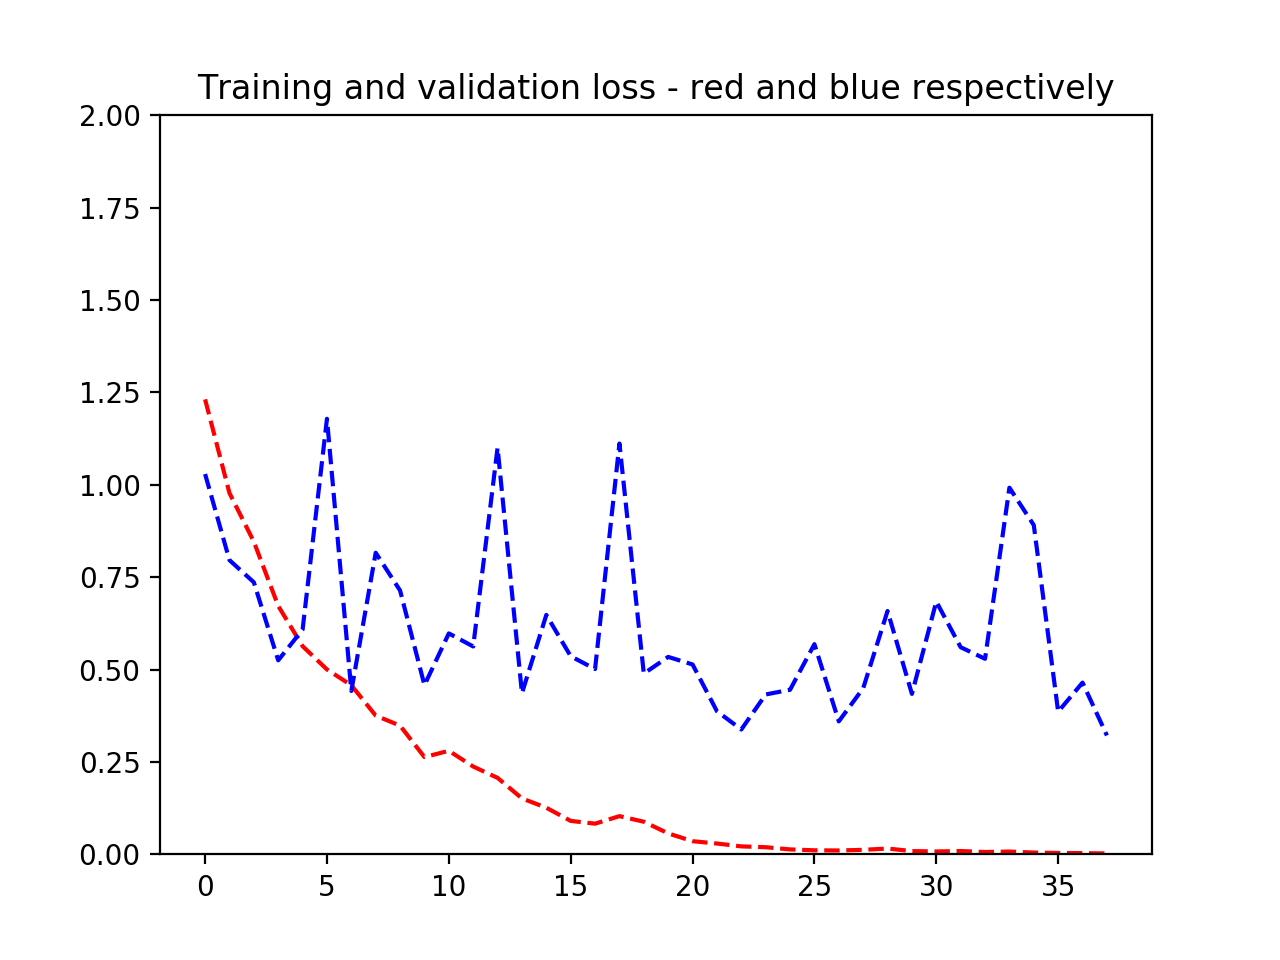

<IPython.core.display.Javascript object>


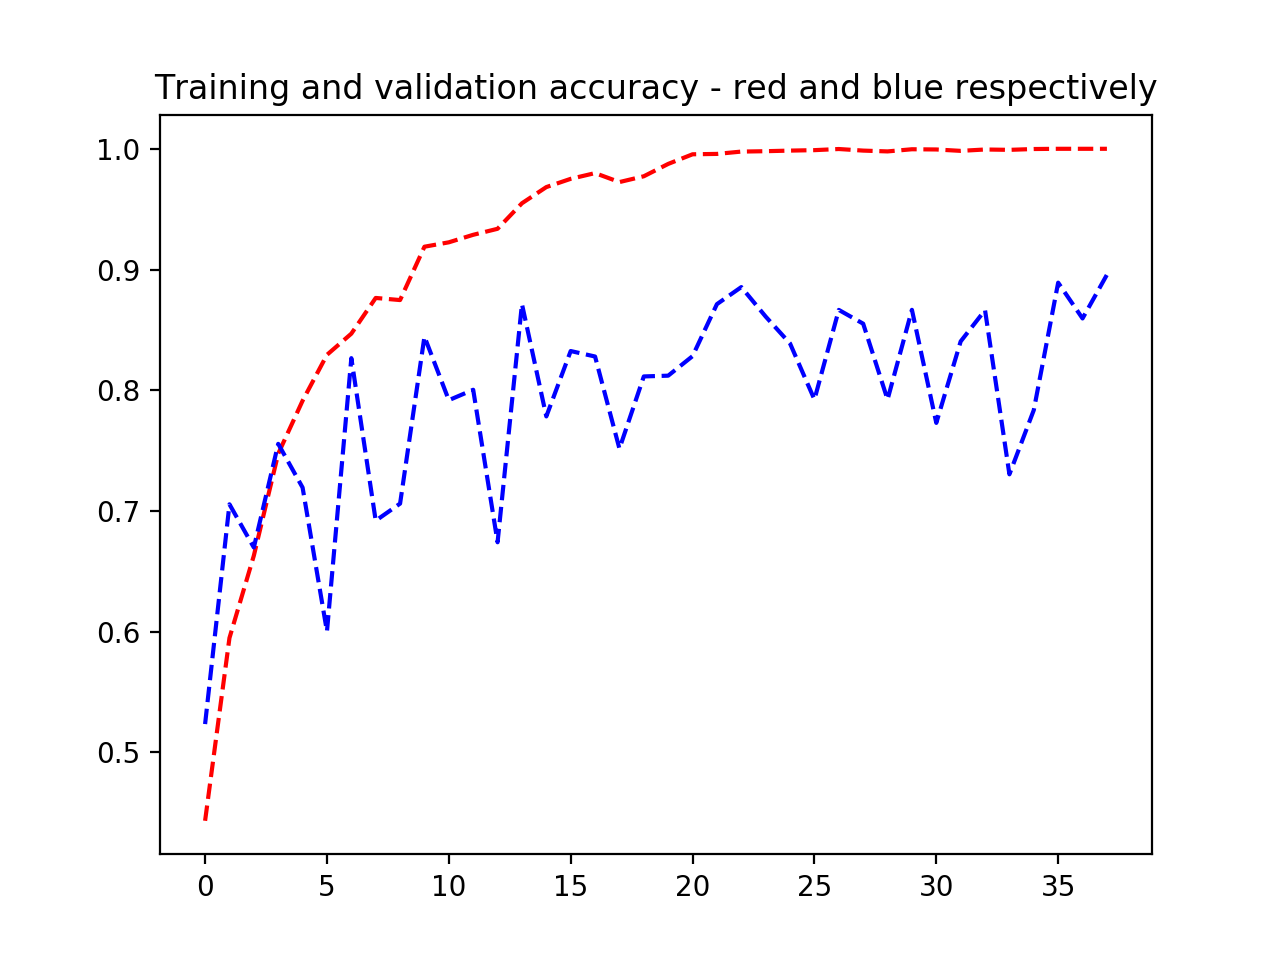

done


In [79]:
saved_dir = '../saved/hdf5_3d_allDAPI/0625_195321'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils

print('done')

In [101]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    #print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    classes = ('endothelium', 'pct', 'vasculature')
    all_pred = []
    all_true = []
    #hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    #heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    #heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            label = np.squeeze(target[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 2:
                #util.visualizationOutGray(data, output, target, classes, normalized)
                a=1
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [102]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/8 [00:00<?, ?it/s]

threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Leaky

100%|██████████| 8/8 [00:00<00:00, 10.31it/s]

num test images = 476
loss = 0.2485
my_metric = 0.9286
f1 = 0.9548
balanced_accuracy = 0.9047
precision = 0.9896
recall = 0.9286
My_metric is accuracy
Confusion matrix, without normalization
[[ 78   5   4]
 [  7 340   4]
 [  4  10  24]]


<IPython.core.display.Javascript object>


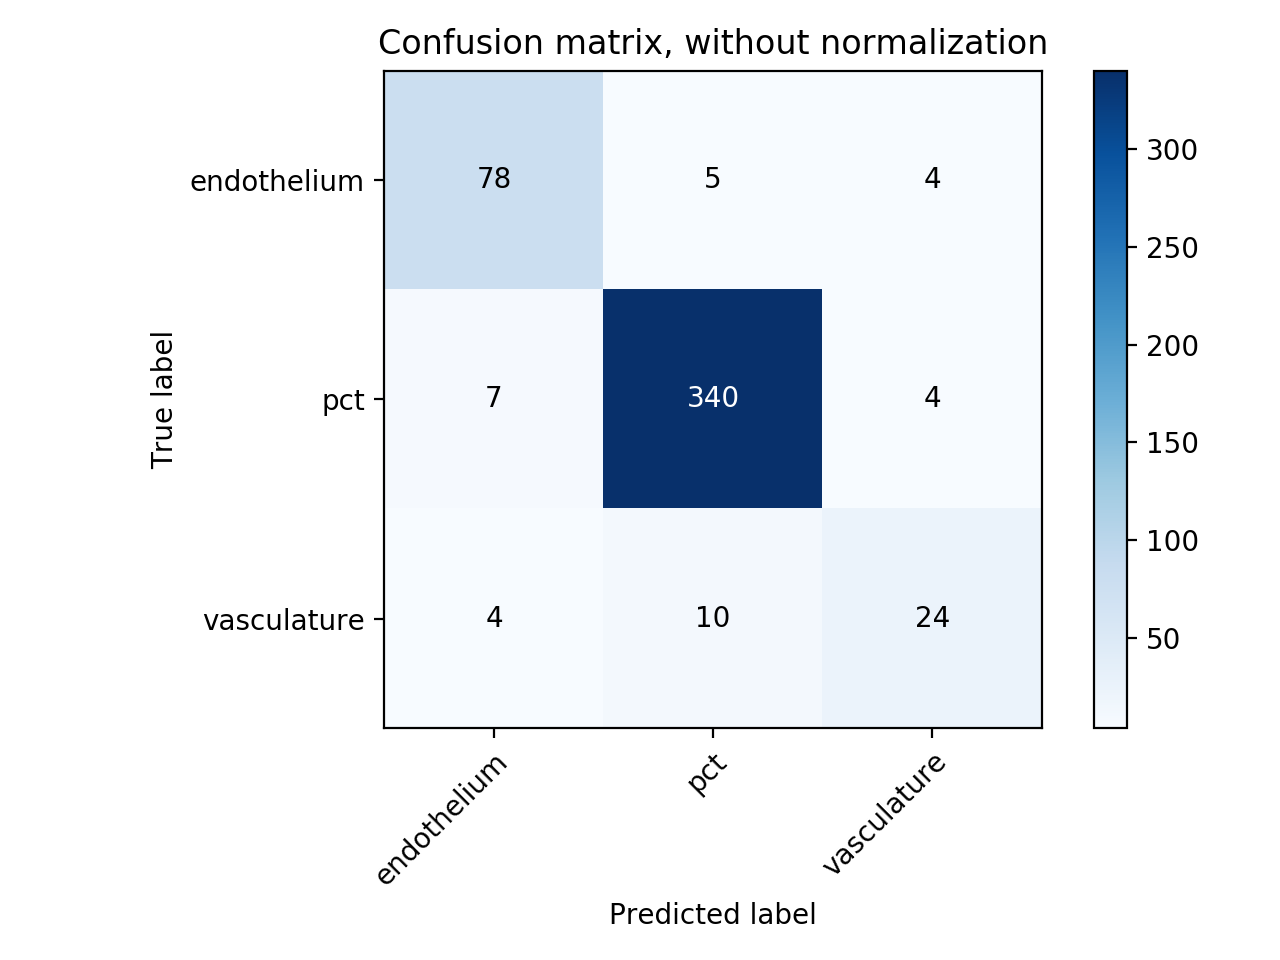

In [103]:
#Test
main2(config, resume)
